In [92]:
#import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import fiona
import shapely

In [93]:
%load_ext autoreload
%autoreload 2

from general_functions import *
pd.set_option('display.max_columns', None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hollands Noorderkwartier

In [94]:
#define relative paths
gpkg_path_HHNK = "../../Data_preprocessed/Waterschappen/HHNK/Noorderkwartier.gpkg"
# gdb_path_HHNK = "../../Data_preprocessed/Waterschappen/HHNK/Watersysteemanalyse_BWN2.gdb"
gdb_path_HHNK_nalevering = "../../Data_preprocessed/Waterschappen/HHNK/Na_levering_HHNK_gemalen_stuwen_20240321.gdb"
output_gpkg_path_HHNK = "../../Data_postprocessed/Waterschappen/HHNK/Noorderkwartier"
interim_results = "../../Interim_results/Waterschappen/HHNK/Noorderkwartier_IR"
peilgebieden_NH_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHNK\20240618_peilgebieden_en_polders\NoordHolland.gpkg"
Texel_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHNK\20240618_peilgebieden_en_polders\Texel.gpkg"
polders_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHNK\20240618_peilgebieden_en_polders\Polders_export_2024-06-18.shp"

In [95]:
#retrieve the data
HHNK = read_gpkg_layers(gpkg_path = gpkg_path_HHNK, 
                        variables = [
                                     # 'stuw', #nalevering
                                     # 'gemaal', #nalevering
                                     'afsluitmiddel',
                                     'hydroobject',
                                     'duikersifonhevel']) 
                                     # 'peilafwijkinggebied', 
                                     # 'peilgebiedpraktijk',
                                     # 'pomp'])
                                     # 'streefpeil'])
                            
#retrieve data from a gdb, as the gpkg of HHNK does not contain all relevant data
# data_gdb = gpd.read_file(gdb_path_HHNK, layer='BWN_ruimtekaart')
HHNK_nalevering = read_gpkg_layers(gpkg_path = gdb_path_HHNK_nalevering, 
                        variables = ['stuw', 'gemaal']) #nalevering

HHNK['stuw'] = HHNK_nalevering['stuw']
HHNK['gemaal'] = HHNK_nalevering['gemaal']

In [96]:
# HHNK['peilgebied'] = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHNK\Na_levering_peilgebieden.gpkg")

In [97]:
from shapely.affinity import translate

def translate_point(point, x_offset=0.01, y_offset=0.01):
    return translate(point, xoff=x_offset, yoff=y_offset)

# Apply the translation to each geometry in the GeoDataFrame
HHNK['gemaal']['geometry'] = HHNK['gemaal']['geometry'].apply(lambda geom: translate_point(geom))


In [98]:
#determine aanvoer en afvoer gemalen
HHNK['gemaal']['func_aanvoer'], HHNK['gemaal']['func_afvoer'], HHNK['gemaal']['func_circulatie']  = False, False, False #default is False
HHNK['gemaal']['functiegemaal'] = HHNK['gemaal']['FUNCTIEGEMAAL'].astype(str) 
HHNK['gemaal'].loc[HHNK['gemaal']['functiegemaal'] == 'onbekend', 'functiegemaal'] = np.nan #replace onbekend with nan, will be filled up later see one line below
HHNK['gemaal'].loc[HHNK['gemaal']['functiegemaal'] == '99', 'functiegemaal'] = np.nan #replace onbekend with nan, will be filled up later see one line below
HHNK['gemaal']['functiegemaal'].fillna(HHNK['gemaal']['OPMERKING'], inplace = True) #some additional is given in this column
HHNK['gemaal'] = HHNK['gemaal'].loc[HHNK['gemaal']['functiegemaal'] != 'niet meer in gebruik'] #filter the gemalen out which are not in use
HHNK['gemaal'] = HHNK['gemaal'].loc[HHNK['gemaal']['functiegemaal'] != '901'] #filter the gemalen out which are not in use

# HHNK['gemaal'].loc[HHNK['gemaal'].functiegemaal.str.contains('onderbemaling|afvoer|af-'), 'func_afvoer'] = True
# HHNK['gemaal'].loc[HHNK['gemaal'].functiegemaal.str.contains('trekker|opmaling|op-|wateraanvoer|aanvoer'), 'func_aanvoer'] = True #aannamen: trekkerpompen vooral voor wateraanvoer
# HHNK['gemaal'].loc[HHNK['gemaal'].functiegemaal.str.contains('doorspoelpomp'), 'func_circulatie'] = True

afvoer_values = ['2', '4', '5', '6', '903']
aanvoer_values = ['1', '3', '5', '902', '903'] #aannamen: trekkerpompen vooral voor wateraanvoer
circulatie_values = ['904']


HHNK['gemaal'].loc[HHNK['gemaal']['functiegemaal'].isin(afvoer_values), 'func_afvoer'] = True
HHNK['gemaal'].loc[HHNK['gemaal']['functiegemaal'].isin(aanvoer_values), 'func_aanvoer'] = True
HHNK['gemaal'].loc[HHNK['gemaal']['functiegemaal'].isin(circulatie_values), 'func_circulatie'] = True

HHNK['gemaal'].loc[(HHNK['gemaal'].func_afvoer == False) &
                       (HHNK['gemaal'].func_aanvoer == False) &
                       (HHNK['gemaal'].func_circulatie == False), 'func_afvoer'] = True #set to afvoergemaal is there the function is unknown

In [99]:
#gemaal
HHNK['gemaal'].rename(columns={'CODE': 'code',
                               'GLOBALID': 'globalid'}, inplace = True)
HHNK['gemaal']['nen3610id'] = 'dummy_nen3610id_' + HHNK['gemaal'].index.astype(str) #create a string as the globalid is usually a str as well

#stuw
HHNK['stuw'].rename(columns={'CODE': 'code',
                               'GLOBALID': 'globalid'}, inplace = True)
HHNK['stuw']['nen3610id'] = 'dummy_nen3610id_' + HHNK['stuw'].index.astype(str) #create a string as the globalid is usually a str as well


### GPKG

In [100]:
# discard irrelevant dataHHNK
HHNK['stuw'] = HHNK['stuw'][['code', 'globalid', 'nen3610id', 'geometry']]
HHNK['gemaal'] = HHNK['gemaal'][['code', 'globalid', 'nen3610id', 'func_afvoer', 'func_aanvoer', 'func_circulatie', 'geometry']]
HHNK['hydroobject'] = HHNK['hydroobject'][['code', 'globalid', 'nen3610id', 'geometry']]
HHNK['afsluitmiddel'] = HHNK['afsluitmiddel'][['code', 'globalid', 'nen3610id', 'geometry']]
HHNK['duikersifonhevel'] = HHNK['duikersifonhevel'][['code', 'globalid', 'nen3610id', 'geometry']]

### Peilgebieden

In [101]:
# peilgebieden = gpd.read_file(peilgebieden_NH_path)
# Texel = gpd.read_file(Texel_path)
# polders = gpd.read_file(polders_path)

# Texel['centroid'] = Texel.centroid

# Texel = gpd.GeoDataFrame(Texel, geometry='centroid')
# polders = gpd.GeoDataFrame(polders, geometry = 'geometry')

# Texel['CODE'] = Texel[['centroid']].sjoin(polders[['CODE', 'geometry']],
#                                           how = 'left',
#                                           predicate = 'within')['CODE']

# peilgebieden = pd.concat([peilgebieden, Texel]).reset_index(drop=True)


In [102]:
# peilgebieden['waterhoogte'] = np.nan
# peilgebieden['waterhoogte'] = peilgebieden['waterhoogte'].fillna(value=peilgebieden.STREEFPEIL)
# peilgebieden.loc[peilgebieden['waterhoogte'] == 0, 'waterhoogte'] = np.nan #replace zero values with NaN

# peilgebieden['waterhoogte'] = peilgebieden['waterhoogte'].fillna(value=peilgebieden.VAST)
# peilgebieden.loc[peilgebieden['waterhoogte'] == 0, 'waterhoogte'] = np.nan #replace zero values with NaN

# peilgebieden['waterhoogte'] = peilgebieden['waterhoogte'].fillna(value=peilgebieden.ZOMER)
# peilgebieden.loc[peilgebieden['waterhoogte'] == 0, 'waterhoogte'] = np.nan #replace zero values with NaN

# peilgebieden['waterhoogte'] = peilgebieden['waterhoogte'].fillna(value=peilgebieden.WINTER)
# peilgebieden.loc[peilgebieden['waterhoogte'] == 0, 'waterhoogte'] = np.nan #replace zero values with NaN

# peilgebieden['waterhoogte'] = peilgebieden['waterhoogte'].fillna(value=peilgebieden.ONDERGRENS)
# peilgebieden.loc[peilgebieden['waterhoogte'] == 0, 'waterhoogte'] = np.nan #replace zero values with NaN

# peilgebieden['waterhoogte'] = peilgebieden['waterhoogte'].fillna(value=peilgebieden.BOVENGRENS)
# peilgebieden.loc[peilgebieden['waterhoogte'] == 0, 'waterhoogte'] = np.nan #replace zero values with NaN

# peilgebieden['waterhoogte'] = peilgebieden['waterhoogte'].fillna(value=peilgebieden.STREEFPE_1)
# peilgebieden.loc[peilgebieden['waterhoogte'] == 0, 'waterhoogte'] = np.nan #replace zero values with NaN

# peilgebieden['waterhoogte'] = peilgebieden['waterhoogte'].fillna(value=peilgebieden.ONDERGRE_1)
# peilgebieden.loc[peilgebieden['waterhoogte'] == 0, 'waterhoogte'] = np.nan #replace zero values with NaN

In [103]:
# peilgebieden['HWS_BZM'] = np.nan
# peilgebieden.loc[peilgebieden.CODE == '03010-01', 'HWS_BZM'] = True
# peilgebieden.loc[peilgebieden.CODE == '1000-01', 'HWS_BZM'] = True
# peilgebieden.loc[peilgebieden.CODE == '1700-01', 'HWS_BZM'] = True
# peilgebieden.loc[peilgebieden.CODE == '1800-01', 'HWS_BZM'] = True

# peilgebieden['polder'] = peilgebieden.CODE.str.split('-').str[0]
# peilgebieden['code'] = peilgebieden.CODE + '_' + peilgebieden.index.astype(str)
# peilgebieden['globalid'] = peilgebieden.OBJECTID
# peilgebieden['nen3610id'] = 'dummy_nen3610id_' + peilgebieden.index.astype(str)
# peilgebieden = peilgebieden[['waterhoogte', 'code', 'nen3610id', 'globalid', 'polder', 'HWS_BZM', 'geometry']]

### The polders and peilgebieden of Texel are different. Load them in seperatly

In [104]:
# aggregation_areas = peilgebieden.dissolve(by='polder')

In [105]:
# peilgebieden['polder'] = peilgebieden['NAAM']


In [106]:
# streefpeil = peilgebieden[['waterhoogte', 'globalid']]
# peilgebied = peilgebieden[['code', 'nen3610id', 'globalid', 'polder', 'HWS_BZM', 'geometry']]

# peilgebied.globalid = 'peilgebied_' + peilgebied.globalid.astype(str)
# #add the data to the dictionary
# HHNK['peilgebied'] = peilgebied

# HHNK['streefpeil'] = streefpeil
# HHNK['streefpeil']['geometry'] = None
# HHNK['streefpeil'] = gpd.GeoDataFrame(HHNK['streefpeil'], geometry = 'geometry')

# #fill False for HWS_BZM (needs to be done for the added areas of Texel)
# HHNK['peilgebied'].HWS_BZM = HHNK['peilgebied'].HWS_BZM.fillna(value=False)

In [107]:
# HHNK['aggregation_area'] = HHNK['peilgebied'].dissolve(by='polder', as_index=False, sort=False)
# HHNK['aggregation_area'].plot()

# Add the boezem and hoofdwatersysteem

Some changes by hand have been made. The resulting shapefile contains the bordering BZM and HWS shapes, including streefpeil

In [108]:
# waterboards = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_30\20240418_samenwerkdag\Oorspronkelijk_LHM_versie\Waterschappen_peilbeheerst.shp").to_crs('EPSG:28992')
# HHNK_boundary = waterboards.loc[waterboards.name == 'Hoogheemraadschap Hollands Noorderkwartier']

In [109]:
# path_HWS_BZM = "..\..\Scripts\Aggregeren\Hoofdwatersysteem\BZM_HWS_HHNK.shp"
# HWS_BZM = gpd.read_file(path_HWS_BZM)
# HWS_BZM = HWS_BZM.clip(HHNK_boundary)

# HWS_BZM = HWS_BZM.loc[HWS_BZM.naam != 'IJsselmeer en Randmeren Noord']
# HWS_BZM = HWS_BZM.loc[HWS_BZM.naam != 'Markermeer & Randmeren Zuid']

# HWS_BZM.plot()

In [110]:
# HWS_BZM.plot()

In [111]:
# HWS_BZM = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_overig\KRW\HHNK\Opgedeelde_boezem_HHNK_definitief2.shp")


In [112]:
# HWS_BZM.loc[HWS_BZM.owmnaam.str.contains('Amstel'), 'zomerpeil'] = -0.4
# HWS_BZM.loc[HWS_BZM.owmnaam.str.contains('Schermer'), 'zomerpeil'] = -0.5
# HWS_BZM.loc[HWS_BZM.owmnaam.str.contains('Alkmaar'), 'zomerpeil'] = -0.5
# HWS_BZM.loc[HWS_BZM.owmnaam.str.contains('VRNK'), 'zomerpeil'] = -0.6

In [113]:
# HWS_BZM['code'] = 'dummy_code_' + (HWS_BZM.index + max(HHNK['peilgebied'].index) + 1).astype(str)
# HWS_BZM['globalid'] = 'dummy_globalid_' + (HWS_BZM.index + max(HHNK['peilgebied'].index) + 1).astype(str)
# HWS_BZM['nen3610id'] = 'dummy_nen3610id_' + (HWS_BZM.index + max(HHNK['peilgebied'].index) + 1).astype(str)
# HWS_BZM['waterhoogte'] = HWS_BZM['zomerpeil']
# HWS_BZM['HWS_BZM'] = True
# HWS_BZM = HWS_BZM[['code', 'globalid', 'nen3610id', 'waterhoogte', 'HWS_BZM', 'geometry']]

# HWS_BZM_peilgebied = HWS_BZM[['code', 'globalid', 'nen3610id', 'HWS_BZM', 'geometry']]
# HWS_BZM_streefpeil = HWS_BZM[['waterhoogte', 'globalid', 'geometry']]

# HHNK['peilgebied'] = gpd.GeoDataFrame(pd.concat([HHNK['peilgebied'], HWS_BZM_peilgebied])).reset_index(drop=True)
# HHNK['streefpeil'] = gpd.GeoDataFrame(pd.concat([HHNK['streefpeil'], HWS_BZM_streefpeil])).reset_index(drop=True)

In [114]:
# HHNK['aggregation_area'] = gpd.GeoDataFrame(pd.concat([HHNK['aggregation_area'][['code', 'nen3610id', 'globalid', 'geometry']], HWS_BZM]), geometry = 'geometry').reset_index(drop=True).to_crs('EPSG:28992')

In [115]:
# #remove the southern part most peilgebieden
# #ERROR SENSITIVE

# HHNK['peilgebied'] = HHNK['peilgebied'].loc[HHNK['peilgebied'].code != 'dummy_code_5165']
# HHNK['peilgebied'] = HHNK['peilgebied'].loc[HHNK['peilgebied'].code != 'dummy_code_5207']
# HHNK['peilgebied'] = HHNK['peilgebied'].loc[HHNK['peilgebied'].code != 'dummy_code_5183']



In [116]:
# from shapely.geometry import Polygon, MultiPolygon, shape, Point
# from shapely.ops import unary_union,cascaded_union 

# def convert_to_polygon(line):
#     if line.is_ring:  # Checks if the LineString is closed
#         return Polygon(line)
#     else:
#         return line  # Returns the line string as is if it's not closed
    
# HHNK['peilgebied'] = HHNK['peilgebied'].explode(ignore_index=True)
# HHNK['peilgebied'] = HHNK['peilgebied'][HHNK['peilgebied'].geometry.type.isin(['Polygon', 'MultiPolygon'])] #also only select polygons


# HHNK['peilgebied']['area'] = HHNK['peilgebied'].area
# dissolved = HHNK['peilgebied'].dissolve()
# exterior = gpd.GeoDataFrame(geometry=dissolved['geometry'].boundary).to_crs(crs='EPSG:28992')
# HHNK['peilgebied'] = HHNK['peilgebied'].to_crs(crs='EPSG:28992')
# exterior = exterior.explode().reset_index(drop=True)
# exterior['geometry'] = exterior['geometry'].apply(convert_to_polygon)
# exterior['area'] = exterior.area
# exterior = exterior.sort_values(by='area', ascending=False).reset_index(drop=True)

# #get rid of some exteriors which should not be filled in
# exterior.dropna(inplace=True)
# exterior.iloc[3::] = exterior
# exterior = exterior.reset_index(drop=True)

# # new_gdf = gpd.GeoDataFrame(columns=HHNK['peilgebied'].columns())

# for i in range(len(exterior)):
#     print(i)
# # for i in range(10):

#     buffered_peilgebied = HHNK['peilgebied'].buffer(0.)

#     exterior_sample = exterior.iloc[i:i+1] #just pick a single sample
#     if exterior_sample['geometry'].values[0] is not None:
#         exterior_sample.geometry = exterior_sample.buffer(0.0001) #let op! hierdoor komt er alsnog een kleine overlap. Maar anders werkt de code even niet, en vanwege tijdgebrek kan dit nu niet worden opgelost. In het bepalen van de crossings wordt hier echter mee omgegaan.

#         intersects_mask = buffered_peilgebied.intersects(exterior_sample.iloc[0].geometry)
#         intersecting_polygons = HHNK['peilgebied'][intersects_mask].sort_values(by='area', ascending=False)

#         if len(intersecting_polygons) > 0:
#             # print(i)
#             # polygon_to_dissolve = intersecting_polygons.iloc[0:1]#.geometry.unary_union  
#             # sample_geometry = exterior_sample.geometry#.unary_union
#             intersecting_polygons = gpd.GeoDataFrame(intersecting_polygons.iloc[0:1], geometry = 'geometry')

#             # dissolved_polygon =   # dissolve/union them
#             all_geometries = list(intersecting_polygons.geometry) + list(exterior_sample.geometry)

#             # Use unary_union to dissolve all polygons in the list
#             dissolved_polygon = unary_union(all_geometries)

#             original_index = intersecting_polygons.index[0]

#             # Ensure it's a single geometry object.
#             # print(len(HHNK['peilgebied'].loc[HHNK['peilgebied'].index == original_index, 'geometry']))
#             # print(len(dissolved_polygon))
#             HHNK['peilgebied'].loc[HHNK['peilgebied'].index == original_index, 'geometry'] = dissolved_polygon#['geometry']
#             # new_gdf = pd.concat([new_gdf, dissolved_polygon])
#         else:
#             print('No intersection found for iteration ', i)

### New peilgebieden and poldergebieden have been deliverd on 04 07 2024

In [149]:
peilgebieden = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHNK\20240704_nieuwe_peil_aggregatie_gebieden\Peilgebieden_export_2024-06-18.shp")
polders = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHNK\20240704_nieuwe_peil_aggregatie_gebieden\Polders_export_2024-06-18.shp")


In [150]:
#Jeroen H asked if the following peilgebieden could be removed from the data (see email 04 07 2024)
codes_to_remove = ['2040-2020', '2040-2030-02', '2040-2060', '2040-2700', '8071-01', '8071-02']
peilgebieden = peilgebieden.loc[~peilgebieden.CODE.isin(codes_to_remove)].reset_index(drop=True)

#add waterhoogte column, and fill it with the streefpeilen
peilgebieden['waterhoogte'] = np.nan

#replace all null values with NaNs
peilgebieden.loc[peilgebieden['VAST'] == 0.0, 'VAST'] = np.nan
peilgebieden.loc[peilgebieden['WINTER'] == 0.0, 'WINTER'] = np.nan
peilgebieden.loc[peilgebieden['ZOMER'] == 0.0, 'ZOMER'] = np.nan
peilgebieden.loc[peilgebieden['STREEFPEIL'] == 0.0, 'STREEFPEIL'] = np.nan
peilgebieden.loc[peilgebieden['ONDERGRENS'] == 0.0, 'ONDERGRENS'] = np.nan
peilgebieden.loc[peilgebieden['BOVENGRENS'] == 0.0, 'BOVENGRENS'] = np.nan

peilgebieden['waterhoogte'].fillna(peilgebieden.VAST, inplace=True)
peilgebieden['waterhoogte'].fillna(peilgebieden.WINTER, inplace=True)
peilgebieden['waterhoogte'].fillna(peilgebieden.ZOMER, inplace=True)
peilgebieden['waterhoogte'].fillna(peilgebieden.STREEFPEIL, inplace=True)
peilgebieden['waterhoogte'].fillna(peilgebieden.ONDERGRENS, inplace=True)
peilgebieden['waterhoogte'].fillna(peilgebieden.BOVENGRENS, inplace=True)

#only sselect the relevant columns
peilgebieden['code'] = peilgebieden['CODE']
peilgebieden['code'] = 'peilgebied_' + peilgebieden['code']
peilgebieden['globalid'] = 'globalid_' + peilgebieden['OBJECTID'].astype(str)
peilgebieden = peilgebieden[['code', 'globalid', 'waterhoogte', 'geometry']]

In [151]:
#add polder ID's to the aggregatiegebieden
peilgebieden['repr_point'] = peilgebieden.representative_point()

peilgebieden = gpd.sjoin(peilgebieden.set_geometry('repr_point'), polders[['CODE', 'NAAM', 'geometry']], how='left', op='within')
peilgebieden.rename(columns={'CODE': 'polder_id',
                             'NAAM': 'nen3610id'}, inplace = True)
peilgebieden['nen3610id'] = peilgebieden['nen3610id'] + '_' + peilgebieden.index.astype(str)


C:\Users\Bruijns\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


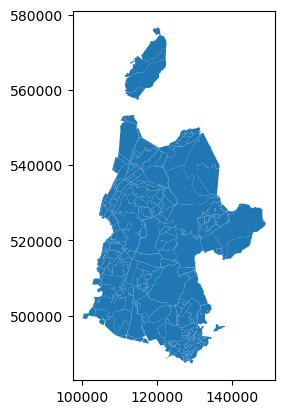

In [153]:
#collect the aggregatiegebieden and streefpeilen
aggregatie_gebieden = peilgebieden.copy(deep=True)
aggregatie_gebieden = gpd.GeoDataFrame(aggregatie_gebieden, geometry = 'geometry')
aggregatie_gebieden = aggregatie_gebieden.dissolve(by='polder_id')
aggregatie_gebieden = aggregatie_gebieden[['code', 'nen3610id', 'globalid', 'geometry']]
aggregatie_gebieden = gpd.GeoDataFrame(aggregatie_gebieden, geometry = 'geometry')
aggregatie_gebieden = aggregatie_gebieden.set_crs('EPSG:28992')

streefpeilen = peilgebieden[['globalid', 'waterhoogte', 'geometry']]
streefpeilen['geometry'] = np.nan
streefpeilen = gpd.GeoDataFrame(streefpeilen, geometry = 'geometry')

peilgebieden = peilgebieden[['code', 'nen3610id', 'globalid', 'geometry']]
peilgebieden = gpd.GeoDataFrame(peilgebieden, geometry = 'geometry')


In [154]:
#add the HWS_BZM to the peilgebieden
HWS_BZM_list = ['peilgebied_1000-01', 'peilgebied_1700-01', 'peilgebied_1800-01', 'peilgebied_03010-01']

peilgebieden['HWS_BZM'] = False
peilgebieden.loc[peilgebieden.code.isin(HWS_BZM_list), 'HWS_BZM'] = True



In [155]:
#Add all variables to the dictionary
HHNK['streefpeil'] = streefpeilen
HHNK['peilgebied'] = peilgebieden
HHNK['aggregation_area'] = aggregatie_gebieden

In [157]:
HHNK['streefpeil'].waterhoogte = HHNK['streefpeil'].waterhoogte.round(2)
HHNK['hydroobject'].code = HHNK['hydroobject'].code + '_' + HHNK['hydroobject'].index.astype(str)


In [158]:
# # HHNK['streefpeil'] = HHNK['peilgebied'][['waterhoogte', 'globalid']]
# HHNK['streefpeil']['geometry'] = None
# HHNK['streefpeil'] = gpd.GeoDataFrame(HHNK['streefpeil'], geometry = 'geometry')

# HHNK['peilgebied'] = HHNK['peilgebied'][['globalid', 'code', 'nen3610id', 'HWS_BZM', 'geometry']]
# HHNK['peilgebied'] = gpd.GeoDataFrame(HHNK['peilgebied'], geometry = 'geometry')

In [159]:
#there are appareantly some comma's included, which causes erros later on. Replace these
HHNK['peilgebied']['globalid'] = HHNK['peilgebied']['globalid'].astype(str).str.replace(',', '_')
HHNK['streefpeil']['globalid'] = HHNK['streefpeil']['globalid'].astype(str).str.replace(',', '_')
HHNK['aggregation_area']['globalid'] = HHNK['aggregation_area']['globalid'].astype(str).str.replace(',', '_')


In [160]:
HHNK['peilgebied'].globalid.fillna(value='dummy_globalid', inplace=True)
HHNK['peilgebied'].loc[HHNK['peilgebied'].globalid == 'dummy_globalid', 'globalid'] = HHNK['peilgebied'].globalid + '_' + HHNK['peilgebied'].index.astype(str) 

HHNK['streefpeil'].globalid.fillna(value='dummy_globalid', inplace=True)
HHNK['streefpeil'].loc[HHNK['streefpeil'].globalid == 'dummy_globalid', 'globalid'] = HHNK['streefpeil'].globalid + '_' + HHNK['streefpeil'].index.astype(str) 

In [161]:
# HHNK['peilgebied']['globalid'] = HHNK['peilgebied']['globalid'].str.replace(',', '_')
# HHNK['peilgebied'].loc[HHNK['peilgebied'].globalid.str.contains(',')]

### Check for the correct keys and columns

In [162]:
show_layers_and_columns(waterschap = HHNK)

afsluitmiddel
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

hydroobject
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

duikersifonhevel
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

stuw
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

gemaal
['code' 'globalid' 'nen3610id' 'func_afvoer' 'func_aanvoer'
 'func_circulatie' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

streefpeil
['globalid' 'waterhoogte' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  None

peilgebied
['code' 'nen3610id' 'globalid' 'geometry' 'HWS_BZM']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

aggregation_area
['code' 'nen3610id' 'globalid' 'geometry']
type

### Store data

In [163]:
store_data(waterschap = HHNK, 
           output_gpkg_path = output_gpkg_path_HHNK)


In [ ]:
print(len(HHNK['peilgebied'].code.unique()))
print(len(HHNK['peilgebied'].globalid.unique()))
print(len(HHNK['hydroobject'].code.unique()))
print(len(HHNK['hydroobject'].code))

<AxesSubplot:>

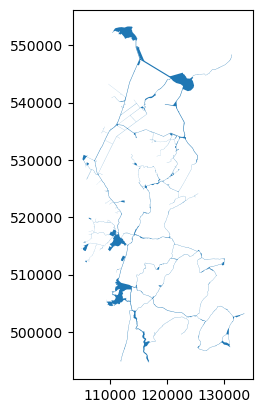

In [90]:
HHNK['peilgebied'].loc[HHNK['peilgebied'].HWS_BZM == True].plot()